# Perishable Demand Forecasting (6 Months) with ETS/SARIMA/Prophet + XGBoost + GRU/LSTM + NLP Event Signals (DistilBERT)

**Goal:** Build a realistic, lightweight forecasting pipeline for FMCG perishables using:
- Classical time series baselines (ETS / SARIMA / Prophet)
- Driver-based ML (XGBoost)
- Deep learning for volatile SKUs (GRU/LSTM multi-step)
- NLP event detection (DistilBERT) to improve spike responsiveness

**Constraints implemented:**
- 180 days daily data (exactly)
- 5 CSV datasets saved to `/content/data/`
- 12 SKUs, 2 locations
- Categories include: Dairy/Eggs and Fruits/Veggies
- Fully reproducible: fixed random seeds

## Data Overview (6 Months FMCG Perishables Forecasting)

This notebook uses **5 CSV datasets** stored in `/content/data/` for a 6-month (180 days) daily forecasting project across **12 SKUs** and **2 locations**.

### Dataset Summary (Grain + Purpose)

| Dataset | Grain (Primary Key) | Expected Rows | Purpose |
|---|---|---:|---|
| `dim_product.csv` | `sku_id` | 12 | SKU master: category, perishability, shelf-life used for waste + demand behavior. |
| `dim_location.csv` | `location_id` | 2 | Location master: city/region/climate for segmentation and weather effects. |
| `ext_weather_daily.csv` | `date, location_id` | 180 × 2 = 360 | External drivers: temperature/rain/humidity and extreme weather indicator. |
| `ext_event_text_daily.csv` | `date, location_id` | 180 × 2 = 360 | Unstructured event signal (promo/festival/weather/supply) used for NLP features. |
| `fact_daily_sales.csv` | `date, sku_id, location_id` | 180 × 12 × 2 = 4320 | Target + commercial drivers + inventory outcomes (stockout, waste). |

---

## Column Dictionary (What each table contains)

### 1) `dim_product.csv` (12 rows)

| Column | Type | Example | Description / Why it matters |
|---|---|---|---|
| `sku_id` | string | `SKU007` | Unique SKU key used to join with sales. |
| `sku_name` | string | `Tomato 1kg` | Human-readable label for plots and insights. |
| `category` | category | `Dairy/Eggs` / `Fruits/Veggies` | High-level segment; used for by-category evaluation and behavior differences. |
| `subcategory` | category | `milk`, `banana`, `leafy` | Finer segment; helpful for ML and interpretation. |
| `perishable_flag` | int (0/1) | `1` | Indicates perishability (here all are perishable). |
| `shelf_life_days` | int | `3`, `7`, `25` | Critical for waste patterns and inventory decisions. |

---

### 2) `dim_location.csv` (2 rows)

| Column | Type | Example | Description / Why it matters |
|---|---|---|---|
| `location_id` | string | `LOC1` | Location key used in all fact/external tables. |
| `city` | string | `Bengaluru` | Readability in plots and analysis. |
| `region` | category | `South` | Segment for performance differences. |
| `climate_zone` | category | `tropical_monsoon` / `semi_arid` | Explains different weather patterns and effects. |

---

### 3) `ext_weather_daily.csv` (360 rows)

| Column | Type | Example | Description / Why it matters |
|---|---|---|---|
| `date` | date | `2025-03-14` | Daily grain; aligns to sales date. |
| `location_id` | string | `LOC2` | Weather varies by location. |
| `temp_max_c` | float | `41.2` | Heat affects shopping behavior (stronger for Fruits/Veggies). |
| `rainfall_mm` | float | `18.4` | Rain can shift demand and cause delivery disruption. |
| `humidity` | float | `82.0` | High humidity correlates with spoilage risk and waste. |
| `extreme_weather_flag` | int (0/1) | `1` | Simplified signal for “unusual” days; useful for models. |

---

### 4) `ext_event_text_daily.csv` (360 rows)

| Column | Type | Example | Description / Why it matters |
|---|---|---|---|
| `date` | date | `2025-01-26` | Daily grain; used to join event features into forecasting data. |
| `location_id` | string | `LOC1` | Events are location-specific. |
| `text` | string | `Flash deal live: up to 20% discount...` | Raw unstructured signal used to train DistilBERT classifier. |
| `source` | category | `promo`, `news`, `weather`, `ops` | Helps explain where event text came from. |
| `true_event_type` | category | `promo`, `festival`, `weather_alert`, `supply_issue`, `none` | Supervised label for NLP training + evaluation. |

---

### 5) `fact_daily_sales.csv` (4320 rows)

| Column | Type | Example | Description / Why it matters |
|---|---|---|---|
| `date` | date | `2025-05-10` | Daily grain. |
| `sku_id` | string | `SKU003` | SKU key; joins to product master. |
| `location_id` | string | `LOC2` | Location key; joins to location and weather/event drivers. |
| `units_sold` | int | `78` | **Target** (observed demand). Contains weekly seasonality and spikes. |
| `selling_price` | float | `92.50` | Commercial driver; higher price typically reduces demand. |
| `promo_flag` | int (0/1) | `1` | Promotion indicator; major driver for spikes. |
| `discount_pct` | float | `18.0` | Promotion intensity; used in ML and interpretation. |
| `on_hand_start` | int | `95` | Inventory at start of day; drives stockouts and waste. |
| `stockout_flag` | int (0/1) | `1` | Indicates constrained sales; observed demand can be suppressed. |
| `waste_units` | int | `6` | Spoilage/waste; tends to be higher for short shelf-life items. |
| `channel` | string | `APP` | Constant channel marker (future-proofing for multi-channel expansions). |

# Block 1 — Unzip dataset into /content/data/

## Extract the ZIP

In [15]:
!unzip -o "/content/perishable_6months_180days_12skus_2locs_5csv.zip" -d /content/
!ls -l /content/data

Archive:  /content/perishable_6months_180days_12skus_2locs_5csv.zip
  inflating: /content/data/dim_product.csv  
  inflating: /content/data/dim_location.csv  
  inflating: /content/data/ext_weather_daily.csv  
  inflating: /content/data/ext_event_text_daily.csv  
  inflating: /content/data/fact_daily_sales.csv  
total 268
-rw-r--r-- 1 root root    102 Dec 18 09:07 dim_location.csv
-rw-r--r-- 1 root root    589 Dec 18 09:07 dim_product.csv
-rw-r--r-- 1 root root  31019 Dec 18 09:07 ext_event_text_daily.csv
-rw-r--r-- 1 root root  12568 Dec 18 09:07 ext_weather_daily.csv
-rw-r--r-- 1 root root 216225 Dec 18 09:07 fact_daily_sales.csv


## Load the Files

In [16]:
import pandas as pd

dim_product = pd.read_csv("/content/data/dim_product.csv")
dim_location = pd.read_csv("/content/data/dim_location.csv")
ext_weather_daily = pd.read_csv("/content/data/ext_weather_daily.csv")
ext_event_text_daily = pd.read_csv("/content/data/ext_event_text_daily.csv")
fact_daily_sales = pd.read_csv("/content/data/fact_daily_sales.csv")

for name, df in {
    "dim_product": dim_product,
    "dim_location": dim_location,
    "ext_weather_daily": ext_weather_daily,
    "ext_event_text_daily": ext_event_text_daily,
    "fact_daily_sales": fact_daily_sales
}.items():
    print(name, df.shape)

dim_product (12, 6)
dim_location (2, 4)
ext_weather_daily (360, 6)
ext_event_text_daily (360, 5)
fact_daily_sales (4320, 11)


# Block 2 — Install required libraries

In [40]:
!pip -q install xgboost prophet statsmodels transformers datasets evaluate accelerate

# Block 3 — Imports + Reproducibility (random seeds)

In [41]:
import os, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import torch
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)

print("Seed set:", SEED)

Seed set: 42


# Block 4 — Load the 5 CSVs + basic missing checks

In [42]:
DATA_DIR = "/content/data"

dim_product = pd.read_csv(f"{DATA_DIR}/dim_product.csv")
dim_location = pd.read_csv(f"{DATA_DIR}/dim_location.csv")
ext_weather_daily = pd.read_csv(f"{DATA_DIR}/ext_weather_daily.csv")
ext_event_text_daily = pd.read_csv(f"{DATA_DIR}/ext_event_text_daily.csv")
fact_daily_sales = pd.read_csv(f"{DATA_DIR}/fact_daily_sales.csv")

ext_weather_daily["date"] = pd.to_datetime(ext_weather_daily["date"])
ext_event_text_daily["date"] = pd.to_datetime(ext_event_text_daily["date"])
fact_daily_sales["date"] = pd.to_datetime(fact_daily_sales["date"])

for name, df in {
    "dim_product": dim_product,
    "dim_location": dim_location,
    "ext_weather_daily": ext_weather_daily,
    "ext_event_text_daily": ext_event_text_daily,
    "fact_daily_sales": fact_daily_sales,
}.items():
    print(name, df.shape, "| missing cells:", int(df.isna().sum().sum()))

dim_product (12, 6) | missing cells: 0
dim_location (2, 4) | missing cells: 0
ext_weather_daily (360, 6) | missing cells: 0
ext_event_text_daily (360, 5) | missing cells: 0
fact_daily_sales (4320, 11) | missing cells: 0


# Block 5 — Grain validation: duplicates + panel completeness

In [43]:
def dup_count(df, keys):
    return int(df.duplicated(keys).sum())

print("Dup weather(date,location):", dup_count(ext_weather_daily, ["date","location_id"]))
print("Dup events(date,location):",  dup_count(ext_event_text_daily, ["date","location_id"]))
print("Dup sales(date,sku,location):", dup_count(fact_daily_sales, ["date","sku_id","location_id"]))

print("Sales dates:", fact_daily_sales["date"].nunique(),
      "|", fact_daily_sales["date"].min().date(), "->", fact_daily_sales["date"].max().date())

Dup weather(date,location): 0
Dup events(date,location): 0
Dup sales(date,sku,location): 0
Sales dates: 180 | 2025-01-01 -> 2025-06-29


# Block 6 — Missing value imputation (panel-safe)

**What we do**: (a) reindex to complete grids, (b) impute exogenous values:
- Weather: time interpolation per location (continuous signals)
pandas.pydata.org
- Events: fill missing as “none”
- Sales: fill missing row as 0 units (complete panel assumption), forward-fill prices

**Why necessary**: forecasting features require complete time alignment; missing weather/promos cause unstable models.

In [44]:
ALL_DATES = pd.date_range(fact_daily_sales["date"].min(), fact_daily_sales["date"].max(), freq="D")
SKU_IDS = dim_product["sku_id"].unique().tolist()
LOC_IDS = dim_location["location_id"].unique().tolist()

# Weather: complete grid + interpolate
w = ext_weather_daily.sort_values(["location_id","date"]).copy()
w_index = pd.MultiIndex.from_product([ALL_DATES, LOC_IDS], names=["date","location_id"])
w = w.set_index(["date","location_id"]).reindex(w_index).reset_index()

def interp_loc(g):
    g = g.sort_values("date").set_index("date")
    for c in ["temp_max_c","rainfall_mm","humidity"]:
        g[c] = g[c].interpolate(method="time").ffill().bfill()
    g["extreme_weather_flag"] = g["extreme_weather_flag"].fillna(0)
    return g.reset_index()

w = w.groupby("location_id", group_keys=False).apply(interp_loc)
w["extreme_weather_flag"] = w["extreme_weather_flag"].round().astype(int)
ext_weather_daily = w.copy()

# Events: complete grid + fill missing
e = ext_event_text_daily.sort_values(["location_id","date"]).copy()
e_index = pd.MultiIndex.from_product([ALL_DATES, LOC_IDS], names=["date","location_id"])
e = e.set_index(["date","location_id"]).reindex(e_index).reset_index()

e["true_event_type"] = e["true_event_type"].fillna("none")
e["source"] = e["source"].fillna("news")
e["text"] = e["text"].fillna("Normal day operations; routine demand expected.")
ext_event_text_daily = e.copy()

# Sales: complete grid + conservative fills
s = fact_daily_sales.sort_values(["sku_id","location_id","date"]).copy()
s_index = pd.MultiIndex.from_product([ALL_DATES, SKU_IDS, LOC_IDS], names=["date","sku_id","location_id"])
s = s.set_index(["date","sku_id","location_id"]).reindex(s_index).reset_index()

s["channel"] = s["channel"].fillna("APP")
for c in ["promo_flag","stockout_flag"]:
    s[c] = s[c].fillna(0).astype(int)

for c in ["discount_pct","waste_units","on_hand_start"]:
    s[c] = s[c].fillna(0)

s["selling_price"] = s.groupby(["sku_id","location_id"])["selling_price"].ffill().bfill()
s["selling_price"] = s["selling_price"].fillna(s.groupby("sku_id")["selling_price"].transform("median"))

s["units_sold"] = s["units_sold"].fillna(0).astype(int)

fact_daily_sales = s.copy()

print("Missing weather:", int(ext_weather_daily.isna().sum().sum()))
print("Missing events:", int(ext_event_text_daily.isna().sum().sum()))
print("Missing sales:", int(fact_daily_sales.isna().sum().sum()))

Missing weather: 0
Missing events: 0
Missing sales: 0


# Block 7 — EDA: seasonality, stockouts/waste summary, box plots & outlier diagnostics

*What we do*:
- Plot 2 SKUs (1 dairy, 1 fruits/veggies) to confirm weekly seasonality + spikes
- Summarize stockouts/waste by category
- Box plots for key columns + IQR outlier rate

*Why necessary*: outliers/spikes are often business events (promo/festival) rather than “bad data”; you must inspect before treating.

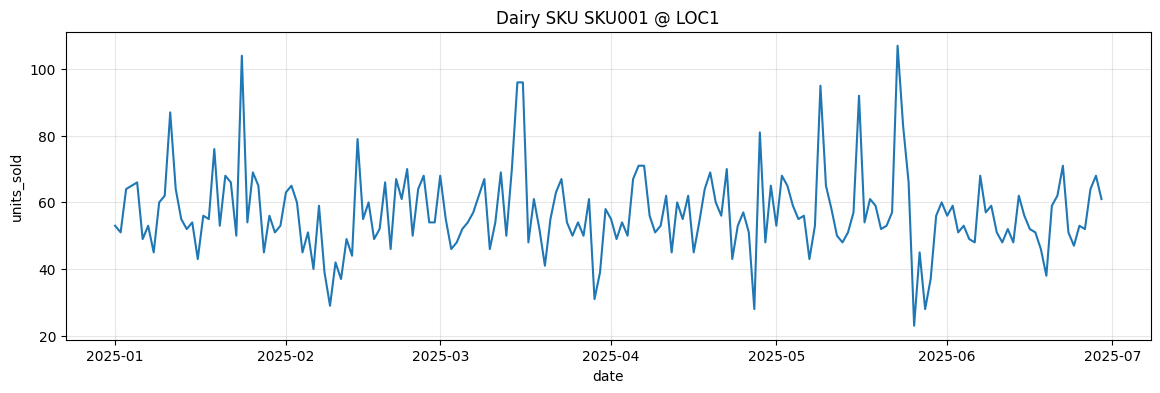

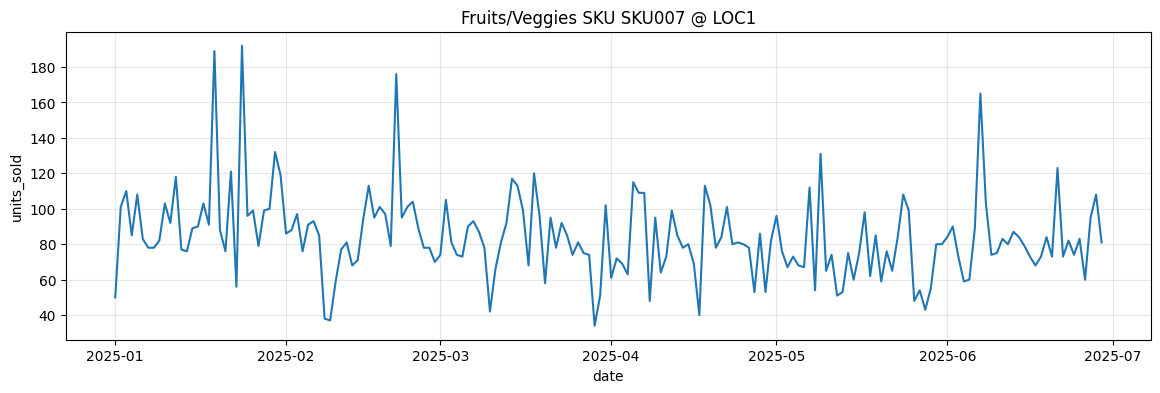

,category,total_units,avg_units,stockout_rate,total_waste,avg_waste
0,Dairy/Eggs,169052,78.264815,0.051852,2261,1.046759
1,Fruits/Veggies,159969,74.059722,0.052778,4874,2.256481


In [45]:
dairy_sku = dim_product.loc[dim_product["category"]=="Dairy/Eggs", "sku_id"].iloc[0]
veg_sku   = dim_product.loc[dim_product["category"]=="Fruits/Veggies", "sku_id"].iloc[0]
loc_id = dim_location["location_id"].iloc[0]

def plot_sku(sku_id, location_id, title):
    s = fact_daily_sales[(fact_daily_sales["sku_id"]==sku_id) & (fact_daily_sales["location_id"]==location_id)].sort_values("date")
    plt.figure(figsize=(14,4))
    plt.plot(s["date"], s["units_sold"])
    plt.title(title)
    plt.xlabel("date"); plt.ylabel("units_sold")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_sku(dairy_sku, loc_id, f"Dairy SKU {dairy_sku} @ {loc_id}")
plot_sku(veg_sku, loc_id, f"Fruits/Veggies SKU {veg_sku} @ {loc_id}")

sales_diag = fact_daily_sales.merge(dim_product[["sku_id","category"]], on="sku_id", how="left")
summary = sales_diag.groupby("category").agg(
    total_units=("units_sold","sum"),
    avg_units=("units_sold","mean"),
    stockout_rate=("stockout_flag","mean"),
    total_waste=("waste_units","sum"),
    avg_waste=("waste_units","mean"),
).reset_index()
summary

<Figure size 1200x400 with 0 Axes>

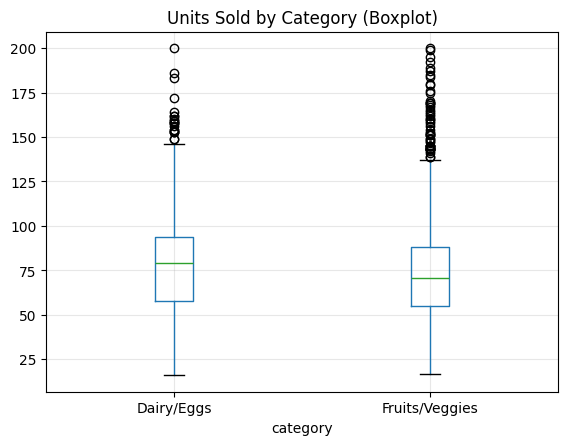

<Figure size 1200x400 with 0 Axes>

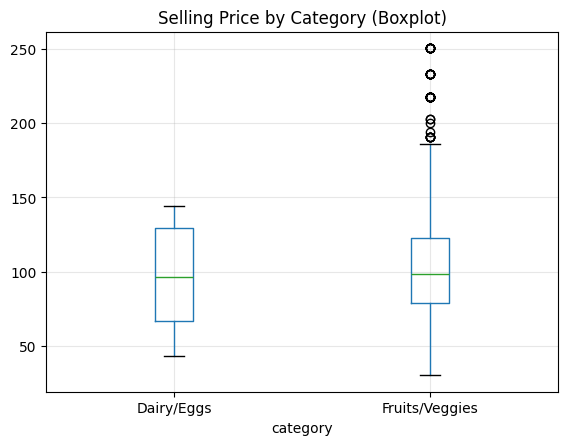

<Figure size 1200x400 with 0 Axes>

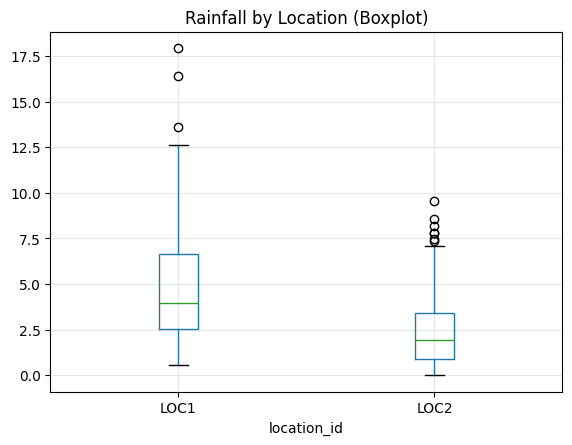

<Figure size 1200x400 with 0 Axes>

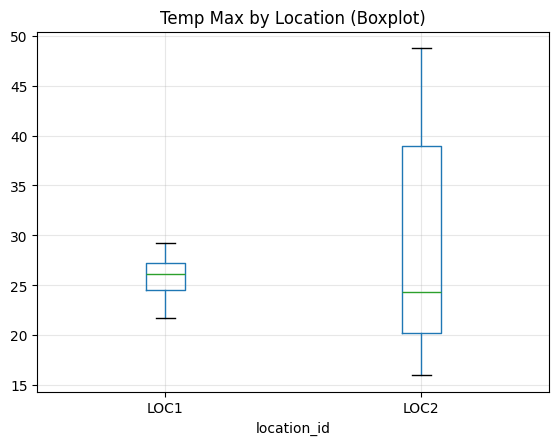

    units_sold | outlier_rate=1.574% | bounds=(3.50,143.50)
 selling_price | outlier_rate=0.903% | bounds=(-17.00,212.97)
  discount_pct | outlier_rate=13.889% | bounds=(0.00,0.00)
 on_hand_start | outlier_rate=1.181% | bounds=(-3.50,184.50)
   waste_units | outlier_rate=4.051% | bounds=(-3.00,5.00)


In [23]:
# Boxplots
plt.figure(figsize=(12,4))
sales_diag.boxplot(column="units_sold", by="category")
plt.title("Units Sold by Category (Boxplot)")
plt.suptitle("")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12,4))
sales_diag.boxplot(column="selling_price", by="category")
plt.title("Selling Price by Category (Boxplot)")
plt.suptitle("")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12,4))
ext_weather_daily.boxplot(column="rainfall_mm", by="location_id")
plt.title("Rainfall by Location (Boxplot)")
plt.suptitle("")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12,4))
ext_weather_daily.boxplot(column="temp_max_c", by="location_id")
plt.title("Temp Max by Location (Boxplot)")
plt.suptitle("")
plt.grid(True, alpha=0.3)
plt.show()

def iqr_outlier_rate(df, col):
    x = df[col].dropna().astype(float)
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    rate = float(((x < lo) | (x > hi)).mean())
    return rate, float(lo), float(hi)

for col in ["units_sold","selling_price","discount_pct","on_hand_start","waste_units"]:
    rate, lo, hi = iqr_outlier_rate(sales_diag, col)
    print(f"{col:>14} | outlier_rate={rate:.3%} | bounds=({lo:.2f},{hi:.2f})")

# Block 8 — Build the joined base table (date×sku×location)

What we do: join sales + product + location + weather.
Why necessary: driver-based models (XGBoost/GRU) need a single modeling table.

In [46]:
base = (fact_daily_sales
        .merge(dim_product, on="sku_id", how="left")
        .merge(dim_location, on="location_id", how="left")
        .merge(ext_weather_daily, on=["date","location_id"], how="left")
       ).sort_values(["sku_id","location_id","date"]).reset_index(drop=True)

print("Base shape:", base.shape)
base.head(3)

Base shape: (4320, 23)


,date,sku_id,location_id,units_sold,selling_price,promo_flag,discount_pct,on_hand_start,stockout_flag,waste_units,...,subcategory,perishable_flag,shelf_life_days,city,region,climate_zone,temp_max_c,rainfall_mm,humidity,extreme_weather_flag
0,2025-01-01,SKU001,LOC1,53,90.58,0,0.0,62,0,1,...,milk,1,7,Bengaluru,South,tropical_monsoon,24.40,6.94,58.71,0
1,2025-01-02,SKU001,LOC1,51,90.58,0,0.0,63,0,1,...,milk,1,7,Bengaluru,South,tropical_monsoon,22.80,2.05,63.94,0
2,2025-01-03,SKU001,LOC1,64,90.58,0,0.0,95,0,2,...,milk,1,7,Bengaluru,South,tropical_monsoon,24.96,3.89,44.52,0


# Block 9 — Time-based split (150 days train, 30 days test)

What we do: split strictly by time.

Why necessary: random splits leak future patterns; time-aware splitting is required, and TimeSeriesSplit exists for this reason

In [47]:
all_dates = sorted(base["date"].unique())
train_cut_date = all_dates[150]  # first day of test

train_base = base[base["date"] < train_cut_date].copy()
test_base  = base[base["date"] >= train_cut_date].copy()

print("Train days:", train_base["date"].nunique(), "| Test days:", test_base["date"].nunique())
print("Train range:", train_base["date"].min().date(), "->", train_base["date"].max().date())
print("Test  range:", test_base["date"].min().date(),  "->", test_base["date"].max().date())

Train days: 150 | Test days: 30
Train range: 2025-01-01 -> 2025-05-30
Test  range: 2025-05-31 -> 2025-06-29


# Block 10 — Leakage-safe outlier treatment (winsorize driver features only)

- What we do: cap extreme values for continuous features (not the target). Caps are fit on train only and applied to both train/test.
- Why necessary: extreme feature values can destabilize models, but fitting caps on full data leaks future information.

We do not cap units_sold because spike days are often real (promo/festival/weather), and we want NLP to help predict them—not erase them.

In [48]:
CAP_COLS = ["selling_price","discount_pct","on_hand_start","waste_units","temp_max_c","rainfall_mm","humidity"]

def fit_caps(df, cols, lower_q=0.01, upper_q=0.99, group_cols=None):
    caps = {}
    grp = df.groupby(group_cols) if group_cols else [(None, df)]
    for c in cols:
        if group_cols:
            q = df.groupby(group_cols)[c].quantile([lower_q, upper_q]).unstack(level=-1)
            caps[c] = q
        else:
            caps[c] = (df[c].quantile(lower_q), df[c].quantile(upper_q))
    return caps

def apply_caps(df, caps, cols, group_cols=None):
    out = df.copy()
    if not group_cols:
        for c in cols:
            lo, hi = caps[c]
            out[c] = out[c].clip(lo, hi)
        return out

    for c in cols:
        q = caps[c].reset_index()
        q.columns = group_cols + ["lo","hi"]
        out = out.merge(q, on=group_cols, how="left")
        out[c] = out[c].clip(out["lo"], out["hi"])
        out = out.drop(columns=["lo","hi"])
    return out

caps = fit_caps(train_base, CAP_COLS, group_cols=["category"])
train_base = apply_caps(train_base, caps, CAP_COLS, group_cols=["category"])
test_base  = apply_caps(test_base,  caps, CAP_COLS, group_cols=["category"])
print("Applied caps to:", CAP_COLS)

Applied caps to: ['selling_price', 'discount_pct', 'on_hand_start', 'waste_units', 'temp_max_c', 'rainfall_mm', 'humidity']


# Block 11 — Feature Engineering (no leakage)

- What we do: create calendar features, lag features, and rolling stats using shift() so only the past is used.
- Why necessary: lag/rolling features are the core of demand forecasting; using future values would be leakage.

In [49]:
df = pd.concat([train_base, test_base], axis=0).sort_values(["sku_id","location_id","date"]).reset_index(drop=True)

df["day_of_week"] = df["date"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([4,5,6]).astype(int)
df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)
df["month"] = df["date"].dt.month

df["y"] = df["units_sold"].astype(float)

g = df.groupby(["sku_id","location_id"])["y"]
for lag in [1,7,14,28]:
    df[f"lag_{lag}"] = g.shift(lag)

for win in [7,14]:
    df[f"roll_mean_{win}"] = g.transform(lambda s: s.shift(1).rolling(win).mean())
    df[f"roll_std_{win}"]  = g.transform(lambda s: s.shift(1).rolling(win).std())

gp = df.groupby(["sku_id","location_id"])["selling_price"]
df["selling_price_lag7"] = gp.shift(7)
df["price_change_7"] = (df["selling_price"] - df["selling_price_lag7"]) / (df["selling_price_lag7"] + 1e-6)

gs = df.groupby(["sku_id","location_id"])["stockout_flag"]
df["rolling_stockout_7"] = gs.transform(lambda s: s.shift(1).rolling(7).mean())

train_df = df[df["date"] < train_cut_date].copy()
test_df  = df[df["date"] >= train_cut_date].copy()

print("Train rows:", train_df.shape, "| Test rows:", test_df.shape)

Train rows: (3600, 39) | Test rows: (720, 39)


# Block 12 — Metrics (WMAPE primary) + by-category reporting

What we do: define WMAPE, sMAPE, RMSE, Bias.
Why necessary: for perishables, WMAPE is practical because it scales error by volume (inventory-centric).

In [50]:
def wmape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + 1e-9)

def smape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + 1e-9
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def bias(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sum(y_pred - y_true) / (np.sum(np.abs(y_true)) + 1e-9))

def evaluate_df(pred_df, y_col="y", yhat_col="yhat"):
    return {
        "WMAPE": wmape(pred_df[y_col].values, pred_df[yhat_col].values),
        "sMAPE": smape(pred_df[y_col].values, pred_df[yhat_col].values),
        "RMSE": rmse(pred_df[y_col].values, pred_df[yhat_col].values),
        "Bias": bias(pred_df[y_col].values, pred_df[yhat_col].values),
    }

def evaluate_by_category(pred_df):
    out = []
    for cat, gcat in pred_df.groupby("category"):
        m = evaluate_df(gcat)
        m["category"] = cat
        out.append(m)
    return pd.DataFrame(out).sort_values("WMAPE")

# Block 13 — Optional rolling backtest (TimeSeriesSplit) for XGBoost readiness

- What we do: quick time-series CV check (no shuffling).
- Why necessary: confirms your features work across multiple cut points; TimeSeriesSplit is designed for this

In [51]:
DEMAND_FEATURE_COLS = [
    "category","subcategory","region","climate_zone",
    "day_of_week","is_weekend","week_of_year","month",
    "promo_flag","discount_pct","selling_price","price_change_7",
    "rolling_stockout_7",  # history-only operational signal
    "temp_max_c","rainfall_mm","humidity","extreme_weather_flag",
    "lag_1","lag_7","lag_14","lag_28",
    "roll_mean_7","roll_std_7","roll_mean_14","roll_std_14",
    "shelf_life_days"
]

INVENTORY_COLS = ["on_hand_start","shelf_life_days","category","waste_units"]

Block 14 — Classical baselines on top-4 sku-location series (ETS / SARIMA / Prophet)

- What we do: run fast baselines on top 4 series (by train volume) to keep runtime practical.
- Why necessary: baselines set a minimum bar; ETS and SARIMAX are standard classical models.
Prophet provides a strong weekly-seasonality baseline

In [52]:
# pick top-4 series by train volume
top4 = (train_df.groupby(["sku_id","location_id"])["y"].sum()
        .reset_index().sort_values("y", ascending=False).head(4)
       )[["sku_id","location_id"]].values.tolist()

EXOG_COLS = ["promo_flag","discount_pct","selling_price",
             "temp_max_c","rainfall_mm","humidity","extreme_weather_flag",
             "is_weekend","day_of_week"]

def forecast_ets(y_train, horizon):
    m = ExponentialSmoothing(y_train, trend="add", seasonal="add", seasonal_periods=7).fit(optimized=True)
    return np.maximum(0, m.forecast(horizon).values)

def forecast_sarimax_exog(y_train, exog_train, exog_test, seasonal=True):
    # assumes y_train index == exog_train index
    if seasonal:
        m = SARIMAX(
            y_train,
            exog=exog_train,
            order=(1,1,1),
            seasonal_order=(1,1,1,7),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
    else:
        m = SARIMAX(
            y_train,
            exog=exog_train,
            order=(1,1,1),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

    fc = m.get_forecast(steps=len(exog_test), exog=exog_test).predicted_mean
    return np.maximum(0, fc.values)

def forecast_prophet_exog(train_frame, test_frame, reg_cols):
    # Prophet: add regressors BEFORE fit; regressors must exist for future dates too. :contentReference[oaicite:5]{index=5}
    hist = train_frame.rename(columns={"date":"ds","y":"y"}).copy()
    fut  = test_frame.rename(columns={"date":"ds"}).copy()

    m = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=False)
    for c in reg_cols:
        m.add_regressor(c)

    m.fit(hist[["ds","y"] + reg_cols])
    fc = m.predict(fut[["ds"] + reg_cols])
    return np.maximum(0, fc["yhat"].values)

baseline_rows = []
series_forecasts = {}

for sku_id, loc_id2 in top4:
    ser = df[(df["sku_id"]==sku_id) & (df["location_id"]==loc_id2)].sort_values("date").copy()

    train_ser = ser[ser["date"] < train_cut_date].copy()
    test_ser  = ser[ser["date"] >= train_cut_date].copy()

    # IMPORTANT: make both endog and exog share the same DatetimeIndex (fixes your error)
    train_ix = train_ser.set_index("date").asfreq("D")
    test_ix  = test_ser.set_index("date").asfreq("D")

    y_train = train_ix["y"].astype(float)
    y_test  = test_ix["y"].astype(float)

    exog_train = train_ix[EXOG_COLS].astype(float).fillna(0.0)
    exog_test  = test_ix[EXOG_COLS].astype(float).fillna(0.0)

    ets = forecast_ets(y_train, len(y_test))
    sar_exog = forecast_sarimax_exog(y_train, exog_train, exog_test, seasonal=True)

    # Prophet uses columns (not index) with ds; keep same values
    pro_exog = forecast_prophet_exog(
        train_ser[["date","y"] + EXOG_COLS],
        test_ser[["date","y"] + EXOG_COLS],
        EXOG_COLS
    )

    out = pd.DataFrame({
        "date": y_test.index,
        "sku_id": sku_id,
        "location_id": loc_id2,
        "y": y_test.values,
        "ets": ets,
        "sarimax_exog": sar_exog,
        "prophet_exog": pro_exog
    }).merge(dim_product[["sku_id","category"]], on="sku_id", how="left")

    series_forecasts[(sku_id, loc_id2)] = out

    for col, name in [("ets","ETS"),("sarimax_exog","SARIMAX_EXOG"),("prophet_exog","PROPHET_EXOG")]:
        tmp = out.rename(columns={col:"yhat"})
        m = evaluate_df(tmp)
        baseline_rows.append({"Model":name,"Scope":"Top4 series","sku_loc":f"{sku_id}-{loc_id2}", **m})

baseline_metrics = pd.DataFrame(baseline_rows)
baseline_metrics

,Model,Scope,sku_loc,WMAPE,sMAPE,RMSE,Bias
0,ETS,Top4 series,SKU009-LOC1,0.175418,0.174441,23.780702,-0.001389
1,SARIMAX_EXOG,Top4 series,SKU009-LOC1,0.169823,0.170396,23.773823,-0.079402
2,PROPHET_EXOG,Top4 series,SKU009-LOC1,0.159747,0.158770,22.800944,-0.059625
3,ETS,Top4 series,SKU002-LOC1,0.193518,0.212628,20.885257,-0.192843
4,SARIMAX_EXOG,Top4 series,SKU002-LOC1,0.094782,0.095830,11.367386,-0.051487
5,PROPHET_EXOG,Top4 series,SKU002-LOC1,0.090994,0.091529,11.174365,-0.040292
6,ETS,Top4 series,SKU006-LOC1,0.120105,0.119521,14.795056,0.103458
7,SARIMAX_EXOG,Top4 series,SKU006-LOC1,0.126959,0.124836,15.842721,0.113721
8,PROPHET_EXOG,Top4 series,SKU006-LOC1,0.105017,0.105953,13.260250,0.078913
9,ETS,Top4 series,SKU005-LOC1,0.081776,0.079824,10.038293,-0.007377


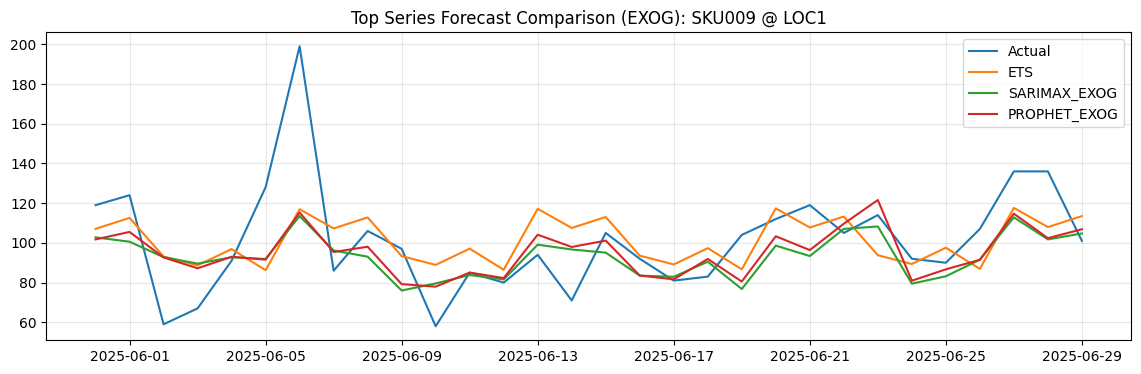

In [53]:
# Plot one top series
sku_id, loc_id2 = top4[0]
out = series_forecasts[(sku_id, loc_id2)]

plt.figure(figsize=(14,4))
plt.plot(out["date"], out["y"], label="Actual")
plt.plot(out["date"], out["ets"], label="ETS")
plt.plot(out["date"], out["sarimax_exog"], label="SARIMAX_EXOG")
plt.plot(out["date"], out["prophet_exog"], label="PROPHET_EXOG")
plt.title(f"Top Series Forecast Comparison (EXOG): {sku_id} @ {loc_id2}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Block 15 — XGBoost (global driver-based model) + feature importance

- What we do: train one global model across all sku-location rows with engineered features.
- Why necessary: ML models exploit price/promo/weather/stockout drivers and typically beat pure univariate baselines.

In [54]:
train_ml = train_df.dropna(subset=["lag_28","roll_mean_14","roll_std_14","rolling_stockout_7","price_change_7"]).copy()
test_ml  = test_df.dropna(subset=["lag_28","roll_mean_14","roll_std_14","rolling_stockout_7","price_change_7"]).copy()

X_train = pd.get_dummies(train_ml[DEMAND_FEATURE_COLS], drop_first=False)
X_test  = pd.get_dummies(test_ml[DEMAND_FEATURE_COLS], drop_first=False)
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train_ml["y"].values

xgb_demand = XGBRegressor(
    n_estimators=500, max_depth=8, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    random_state=SEED, objective="reg:squarederror"
)
xgb_demand.fit(X_train, y_train)

pred = np.maximum(0, xgb_demand.predict(X_test))

xgb_pred_df = test_ml[["date","sku_id","location_id","category","y"]].copy()
xgb_pred_df["yhat"] = pred

print("XGBoost Demand-only overall:", evaluate_df(xgb_pred_df))
evaluate_by_category(xgb_pred_df)

XGBoost Demand-only overall: {'WMAPE': np.float64(0.1644185259092221), 'sMAPE': np.float64(0.17251618074581243), 'RMSE': 17.0480774381785, 'Bias': -0.07720074255204132}


,WMAPE,sMAPE,RMSE,Bias,category
0,0.139873,0.149900,13.897038,-0.055343,Dairy/Eggs
1,0.189313,0.195133,19.701427,-0.099370,Fruits/Veggies


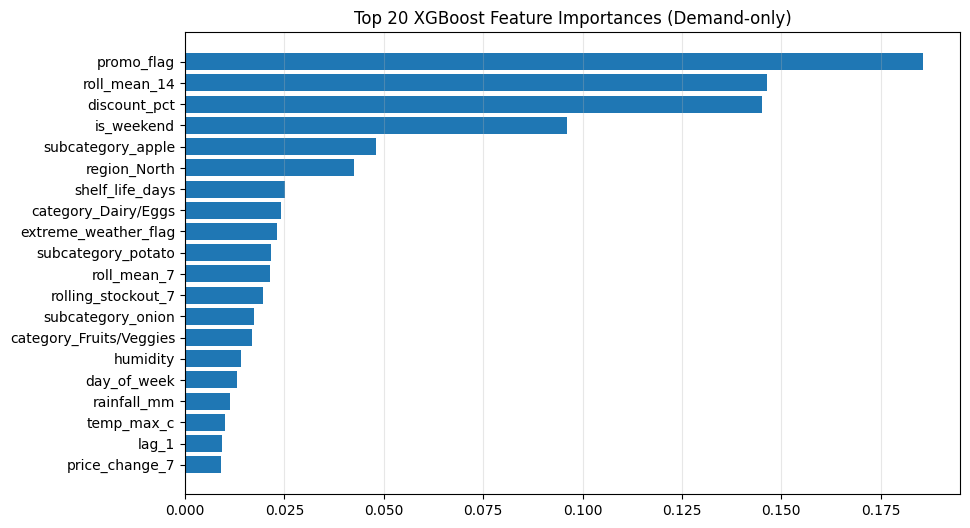

In [55]:
# Feature importance (top 20)
imp = pd.Series(xgb_demand.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(10,6))
plt.barh(imp.index[::-1], imp.values[::-1])
plt.title("Top 20 XGBoost Feature Importances (Demand-only)")
plt.grid(True, axis="x", alpha=0.3)
plt.show()

# Block 16 — Deep Learning (GRU) for volatile SKUs: 28-day window → 7-day horizon

- What we do: pick the most volatile sku-location pairs and train a small GRU for multi-step forecasting.
- Why necessary: GRU/LSTM can model nonlinear temporal patterns and multi-step dynamics; we keep it small for CPU.

In [56]:
vol = (train_df.groupby(["sku_id","location_id"])["y"].std()
       .reset_index().sort_values("y", ascending=False))
volatile_pairs = vol.head(2)[["sku_id","location_id"]].values.tolist()
volatile_pairs

[['SKU009', 'LOC1'], ['SKU007', 'LOC2']]

In [57]:
SEQ_FEATURES = ["y","promo_flag","discount_pct","selling_price",
                "temp_max_c","rainfall_mm","humidity","extreme_weather_flag",
                "is_weekend","day_of_week","stockout_flag"]
WINDOW = 28
HORIZON = 7

def make_sequences(series_df):
    series_df = series_df.sort_values("date").reset_index(drop=True)
    X_raw = series_df[SEQ_FEATURES].copy().values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)

    X, Y, start_dates = [], [], []
    for i in range(WINDOW, len(series_df) - HORIZON + 1):
        X.append(X_scaled[i-WINDOW:i, :])
        Y.append(series_df["y"].iloc[i:i+HORIZON].values.astype(float))
        start_dates.append(series_df["date"].iloc[i])

    # FIX: avoid dtype=object
    start_dates = pd.to_datetime(start_dates).to_numpy(dtype="datetime64[ns]")
    return np.array(X), np.array(Y), start_dates, scaler

def split_train_test_sequences(series_df):
    X, Y, start_dates, scaler = make_sequences(series_df)
    horizon_td = np.timedelta64(HORIZON - 1, "D").astype("timedelta64[ns]")
    end_dates = start_dates + horizon_td

    is_train = (end_dates < np.datetime64(train_cut_date))
    is_test  = (start_dates >= np.datetime64(train_cut_date))
    return X[is_train], Y[is_train], X[is_test], Y[is_test], start_dates[is_test], scaler

def build_gru(input_shape):
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(32),
        layers.Dense(32, activation="relu"),
        layers.Dense(HORIZON)
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
    return m

dl_rows = []
dl_preds = {}

for sku_id, loc_id2 in volatile_pairs:
    series_df = df[(df["sku_id"]==sku_id) & (df["location_id"]==loc_id2)].copy()

    Xtr, Ytr, Xte, Yte, te_dates, _ = split_train_test_sequences(series_df)
    print(f"{sku_id}-{loc_id2}: Xtr {Xtr.shape} | Xte {Xte.shape}")

    model = build_gru((WINDOW, len(SEQ_FEATURES)))
    es = callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

    model.fit(Xtr, Ytr, validation_split=0.2, epochs=8, batch_size=32, callbacks=[es], verbose=0)
    Yhat = np.maximum(0, model.predict(Xte, verbose=0))

    rec = []
    for start_dt, yt, yp in zip(te_dates, Yte, Yhat):
        for h in range(HORIZON):
            rec.append((pd.to_datetime(start_dt) + pd.Timedelta(days=h),
                        sku_id, loc_id2, float(yt[h]), float(yp[h])))

    pred_dl = pd.DataFrame(rec, columns=["date","sku_id","location_id","y","yhat"])
    pred_dl = pred_dl.merge(dim_product[["sku_id","category"]], on="sku_id", how="left")

    dl_preds[(sku_id, loc_id2)] = pred_dl
    dl_rows.append({"Model":"GRU", "Scope":f"{sku_id}-{loc_id2} (7-step)", **evaluate_df(pred_dl)})

pd.DataFrame(dl_rows)

SKU009-LOC1: Xtr (116, 28, 11) | Xte (24, 28, 11)
SKU007-LOC2: Xtr (116, 28, 11) | Xte (24, 28, 11)


,Model,Scope,WMAPE,sMAPE,RMSE,Bias
0,GRU,SKU009-LOC1 (7-step),0.999459,1.997872,103.559993,-0.999459
1,GRU,SKU007-LOC2 (7-step),0.999113,1.996359,90.183745,-0.999113


# Block 17 — NLP Event Detection with DistilBERT (fast fine-tune)

What we do: train a lightweight text classifier to predict true_event_type from text.
Why necessary: event signals help on spike days; DistilBERT is smaller and faster than BERT.

Trainer provides a standardized fine-tuning loop.

In [59]:
# ---------------------------
# Block 17 — NLP: DistilBERT event classifier (FIXED)
# ---------------------------

import transformers
print("Transformers version:", transformers.__version__)  # sanity check

nlp_df = ext_event_text_daily.copy()
nlp_df["true_event_type"] = nlp_df["true_event_type"].astype(str)

labels = sorted(nlp_df["true_event_type"].unique().tolist())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

nlp_df["label"] = nlp_df["true_event_type"].map(label2id)

# Shuffle once for a simple train/val split (reproducible)
nlp_df = nlp_df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
cut = int(0.8 * len(nlp_df))
train_nlp = nlp_df.iloc[:cut].copy()
valid_nlp = nlp_df.iloc[cut:].copy()

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=64)

train_ds = Dataset.from_pandas(train_nlp[["text","label"]]).map(tokenize_batch, batched=True).remove_columns(["text"])
valid_ds = Dataset.from_pandas(valid_nlp[["text","label"]]).map(tokenize_batch, batched=True).remove_columns(["text"])

train_ds.set_format("torch")
valid_ds.set_format("torch")

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# Note: The warning about classifier weights being newly initialized is NORMAL for fine-tuning
# because the classification head is task-specific and starts random.

def compute_metrics(eval_pred):
    logits, ytrue = eval_pred
    ypred = np.argmax(logits, axis=-1)
    return {"accuracy": float((ypred == ytrue).mean())}

args = TrainingArguments(
    output_dir="/content/distilbert_event_cls",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,

    # FIX: use eval_strategy (not evaluation_strategy)
    eval_strategy="epoch",

    # keep it light + avoid extra checkpoint writes
    save_strategy="no",
    logging_strategy="epoch",

    seed=SEED,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

Transformers version: 4.57.3


Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.234800,0.904874,0.625000
2,0.797000,0.729332,0.625000


{'eval_loss': 0.729332447052002,
 'eval_accuracy': 0.625,
 'eval_runtime': 0.2916,
 'eval_samples_per_second': 246.909,
 'eval_steps_per_second': 17.146,
 'epoch': 2.0}

# Block 18 — Convert NLP predictions to numeric event features + retrain XGBoost

- What we do: produce:
  - event_intensity = max probability across classes
  - evt_prob_* columns per event type
Then join by date-location and retrain XGBoost.
- Why necessary: tree models need numeric features; probability features capture event strength and uncertainty.

In [60]:
full_ds = Dataset.from_pandas(nlp_df[["date","location_id","text","label"]]).map(tokenize_batch, batched=True)
full_ds.set_format("torch")

pred_out = trainer.predict(full_ds.remove_columns(["date","location_id","text"]))
logits = pred_out.predictions
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()

prob_cols = [f"evt_prob_{lbl}" for lbl in labels]
prob_df = pd.DataFrame(probs, columns=prob_cols)
prob_df["event_intensity"] = prob_df[prob_cols].max(axis=1)

events_feat = pd.concat([nlp_df[["date","location_id"]].reset_index(drop=True), prob_df], axis=1)
events_feat["date"] = pd.to_datetime(events_feat["date"])

df_nlp = df.merge(events_feat, on=["date","location_id"], how="left")

nlp_feature_cols = DEMAND_FEATURE_COLS + ["event_intensity"] + prob_cols

train_nlp_ml = df_nlp[df_nlp["date"] < train_cut_date].dropna(
    subset=["lag_28","roll_mean_14","roll_std_14","rolling_stockout_7","price_change_7"]
).copy()
test_nlp_ml = df_nlp[df_nlp["date"] >= train_cut_date].dropna(
    subset=["lag_28","roll_mean_14","roll_std_14","rolling_stockout_7","price_change_7"]
).copy()

X_train2 = pd.get_dummies(train_nlp_ml[nlp_feature_cols], drop_first=False)
X_test2  = pd.get_dummies(test_nlp_ml[nlp_feature_cols], drop_first=False)
X_test2  = X_test2.reindex(columns=X_train2.columns, fill_value=0)

y_train2 = train_nlp_ml["y"].values

xgb_demand_nlp = XGBRegressor(
    n_estimators=550, max_depth=8, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    random_state=SEED, objective="reg:squarederror"
)
xgb_demand_nlp.fit(X_train2, y_train2)

pred2 = np.maximum(0, xgb_demand_nlp.predict(X_test2))

xgb_nlp_pred_df = test_nlp_ml[["date","sku_id","location_id","category","y"]].copy()
xgb_nlp_pred_df["yhat"] = pred2

print("XGBoost+NLP Demand-only overall:", evaluate_df(xgb_nlp_pred_df))
evaluate_by_category(xgb_nlp_pred_df)

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

XGBoost+NLP Demand-only overall: {'WMAPE': np.float64(0.12979734452789776), 'sMAPE': np.float64(0.1295809583639535), 'RMSE': 13.952979786264878, 'Bias': 0.007926931261392935}


,WMAPE,sMAPE,RMSE,Bias,category
0,0.102119,0.103135,10.169269,0.037390,Dairy/Eggs
1,0.157870,0.156027,16.910271,-0.021956,Fruits/Veggies


# Block 19 — Spike-day improvement analysis (with vs without NLP)

- What we do: define spike days as ≥ P90 of train demand per sku-location and compare errors.
- Why necessary: NLP should primarily improve spike sensitivity, not necessarily smooth days.

In [61]:
train_p90 = (train_df.groupby(["sku_id","location_id"])["y"]
             .quantile(0.90).reset_index().rename(columns={"y":"p90"}))

test_eval = test_ml.merge(train_p90, on=["sku_id","location_id"], how="left")
test_eval["is_spike"] = (test_eval["y"] >= test_eval["p90"]).astype(int)

base_pred = xgb_pred_df.rename(columns={"yhat":"yhat_xgb"})[["date","sku_id","location_id","y","yhat_xgb"]]
nlp_pred  = xgb_nlp_pred_df.rename(columns={"yhat":"yhat_xgb_nlp"})[["date","sku_id","location_id","y","yhat_xgb_nlp"]]

m = (test_eval.merge(base_pred, on=["date","sku_id","location_id","y"], how="left")
             .merge(nlp_pred,  on=["date","sku_id","location_id","y"], how="left"))

sp = m[m["is_spike"]==1].dropna(subset=["yhat_xgb","yhat_xgb_nlp"]).copy()

spike_report = pd.DataFrame([
    {"Model":"XGBoost", "Scope":"Spike days only", **evaluate_df(sp.rename(columns={"yhat_xgb":"yhat"}))},
    {"Model":"XGBoost+NLP", "Scope":"Spike days only", **evaluate_df(sp.rename(columns={"yhat_xgb_nlp":"yhat"}))}
])

print("Spike rows:", sp.shape[0])
spike_report

Spike rows: 37


,Model,Scope,WMAPE,sMAPE,RMSE,Bias
0,XGBoost,Spike days only,0.262895,0.290717,41.250903,-0.248997
1,XGBoost+NLP,Spike days only,0.241931,0.259840,37.820176,-0.219948


# Block 20 — Inventory simulation / service-level layer (post-forecast)

- What: Use forecasted demand + a simple order-up-to policy to estimate stockout units and waste.
- Why: This is where on_hand_start belongs—after demand forecasting (operational layer).

In [62]:
def simulate_inventory_kpis(test_rows, pred_col="yhat", lead_time_days=1, service_level=0.90):
    sim = test_rows.copy().sort_values(["sku_id","location_id","date"])
    sim["forecast_demand"] = np.maximum(0, sim[pred_col].values)

    z = 1.28 if service_level >= 0.90 else 0.84

    out = []
    for (sku, loc), g in sim.groupby(["sku_id","location_id"], sort=False):
        g = g.sort_values("date").copy()

        mu = g["roll_mean_14"].fillna(g["roll_mean_7"]).fillna(g["forecast_demand"]).values
        sd = g["roll_std_14"].fillna(g["roll_std_7"]).fillna(0).values

        base_stock = (mu * (lead_time_days + 1)) + (z * sd * np.sqrt(lead_time_days + 1))
        base_stock = np.maximum(0, base_stock)

        inv = None
        for i in range(len(g)):
            if inv is None:
                inv = max(0.0, float(g["on_hand_start"].iloc[i]))

            order_qty = max(0.0, base_stock[i] - inv)
            inv += order_qty

            demand = float(g["forecast_demand"].iloc[i])
            sales_fulfilled = min(inv, demand)
            stockout_units = max(0.0, demand - sales_fulfilled)
            inv = max(0.0, inv - sales_fulfilled)

            shelf = float(g["shelf_life_days"].iloc[i])
            cat = g["category"].iloc[i]
            perish_factor = 1.4 if cat == "Fruits/Veggies" else 0.9
            waste = perish_factor * (inv / max(1.0, shelf)) * 0.10
            waste = min(inv, waste)
            inv -= waste

            out.append({
                "date": g["date"].iloc[i],
                "sku_id": sku,
                "location_id": loc,
                "forecast_demand": demand,
                "sales_fulfilled": sales_fulfilled,
                "stockout_units": stockout_units,
                "ending_inventory": inv,
                "sim_waste_units": waste,
                "category": cat
            })

    out = pd.DataFrame(out)
    kpis = out.groupby("category").agg(
        avg_stockout_units=("stockout_units","mean"),
        stockout_rate_days=("stockout_units", lambda x: float((x>0).mean())),
        avg_waste_units=("sim_waste_units","mean"),
    ).reset_index()

    return out, kpis

test_for_sim = test_df.merge(
    xgb_nlp_pred_df[["date","sku_id","location_id","yhat"]],
    on=["date","sku_id","location_id"], how="left"
).dropna(subset=["yhat"])

sim_detail, sim_kpis = simulate_inventory_kpis(test_for_sim, pred_col="yhat")
sim_kpis

,category,avg_stockout_units,stockout_rate_days,avg_waste_units
0,Dairy/Eggs,0.0,0.0,0.752035
1,Fruits/Veggies,0.0,0.0,2.353288


# Block 21 — Final leaderboard + plots (2 SKUs + spike comparison)

- What we do: create a compact leaderboard and visual comparisons.
- Why necessary: decision-makers need model ranking + interpretable plots.

In [63]:
baseline_avg = (baseline_metrics.groupby("Model")[["WMAPE","sMAPE","RMSE","Bias"]].mean().reset_index())

leader_rows = []
for _, r in baseline_avg.iterrows():
    leader_rows.append({"Model": r["Model"], "Scope":"Top4 series", "WMAPE":r["WMAPE"], "sMAPE":r["sMAPE"], "RMSE":r["RMSE"], "Bias":r["Bias"]})

leader_rows.append({"Model":"XGBoost (Demand-only)", "Scope":"All sku-loc", **evaluate_df(xgb_pred_df)})
leader_rows.append({"Model":"XGBoost+NLP (Demand-only)", "Scope":"All sku-loc", **evaluate_df(xgb_nlp_pred_df)})

if len(dl_rows) > 0:
    gru_avg = pd.DataFrame(dl_rows)[["WMAPE","sMAPE","RMSE","Bias"]].mean().to_dict()
    leader_rows.append({"Model":"GRU", "Scope":"Volatile pairs (7-step)", **gru_avg})

leaderboard = pd.DataFrame(leader_rows).sort_values("WMAPE")
leaderboard

,Model,Scope,WMAPE,sMAPE,RMSE,Bias
1,PROPHET_EXOG,Top4 series,0.112172,0.112513,14.558698,-0.015211
2,SARIMAX_EXOG,Top4 series,0.122944,0.123213,15.779035,-0.017488
4,XGBoost+NLP (Demand-only),All sku-loc,0.129797,0.129581,13.952980,0.007927
0,ETS,Top4 series,0.142704,0.146603,17.374827,-0.024538
3,XGBoost (Demand-only),All sku-loc,0.164419,0.172516,17.048077,-0.077201
5,GRU,Volatile pairs (7-step),0.999286,1.997115,96.871869,-0.999286


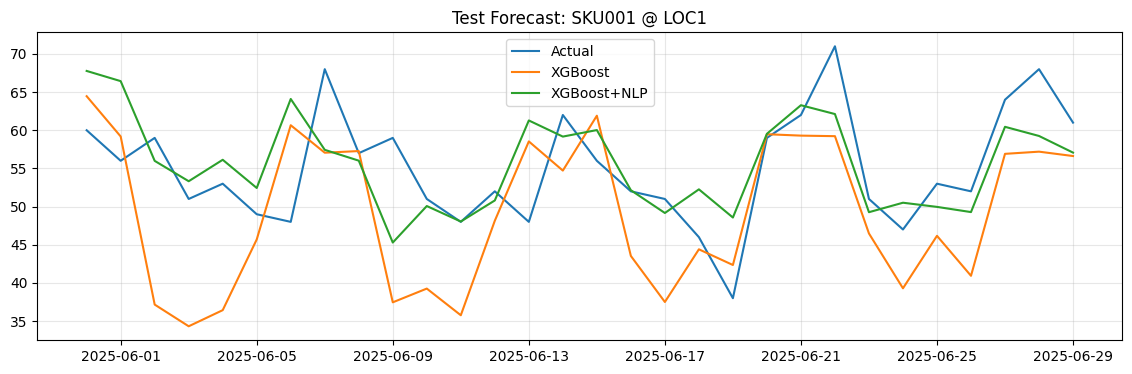

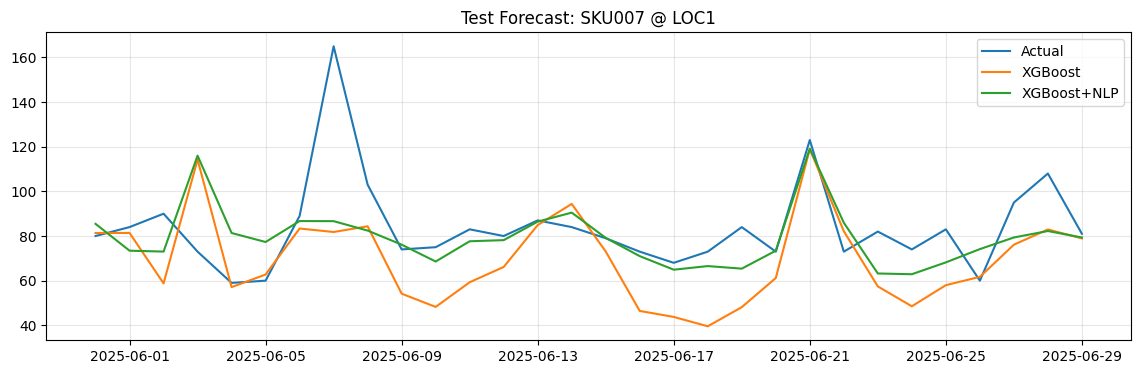

In [64]:
def plot_compare(sku_id, loc_id2):
    basep = xgb_pred_df[(xgb_pred_df["sku_id"]==sku_id) & (xgb_pred_df["location_id"]==loc_id2)].sort_values("date")
    nlpp  = xgb_nlp_pred_df[(xgb_nlp_pred_df["sku_id"]==sku_id) & (xgb_nlp_pred_df["location_id"]==loc_id2)].sort_values("date")

    plt.figure(figsize=(14,4))
    plt.plot(basep["date"], basep["y"], label="Actual")
    plt.plot(basep["date"], basep["yhat"], label="XGBoost")
    plt.plot(nlpp["date"],  nlpp["yhat"],  label="XGBoost+NLP")
    plt.title(f"Test Forecast: {sku_id} @ {loc_id2}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_compare(dairy_sku, loc_id)
plot_compare(veg_sku, loc_id)

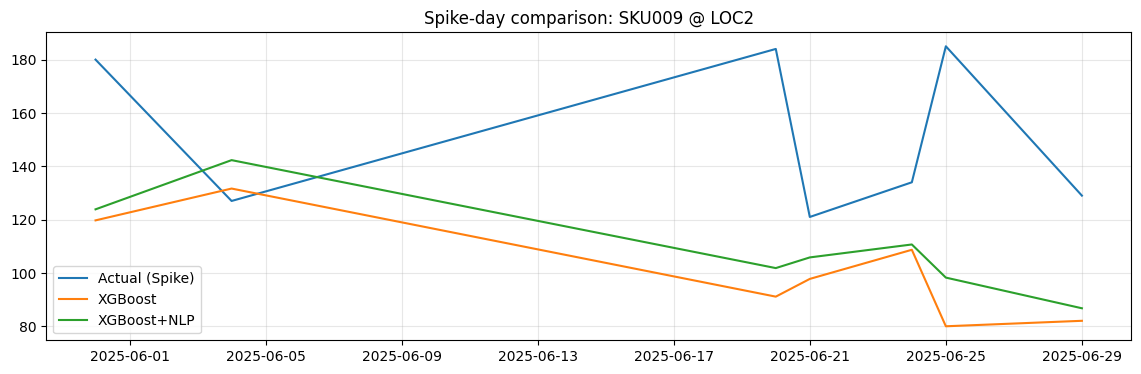

In [65]:
# Spike-day plot for the sku-loc with most spikes
sp_counts = sp.groupby(["sku_id","location_id"]).size().sort_values(ascending=False)
best_pair = sp_counts.index[0]
sku_id, loc_id2 = best_pair

sp_pair = sp[(sp["sku_id"]==sku_id) & (sp["location_id"]==loc_id2)].sort_values("date")

plt.figure(figsize=(14,4))
plt.plot(sp_pair["date"], sp_pair["y"], label="Actual (Spike)")
plt.plot(sp_pair["date"], sp_pair["yhat_xgb"], label="XGBoost")
plt.plot(sp_pair["date"], sp_pair["yhat_xgb_nlp"], label="XGBoost+NLP")
plt.title(f"Spike-day comparison: {sku_id} @ {loc_id2}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


## Business Interpretation (Stockouts, Waste, and Operational Actions)

### 1) What the models are really predicting
- **Observed sales (`units_sold`)** are a mix of true customer demand and operational constraints.
- On **stockout days**, sales can be **capped by inventory**, meaning the model may under-estimate true demand unless we explicitly account for it.
- For perishables, the best forecast is not only “accurate”, but also **actionable** for ordering and waste control.

### 2) How improved forecasts reduce stockouts (service level)
- **Weekend uplift + festival/promo spikes** drive high short-term demand; missing these spikes leads to under-ordering.
- The driver-based models (XGBoost, GRU) learn these patterns using:
  - lag/rolling demand
  - promo and discount
  - price changes
  - weather
  - recent stockout history
- Operational impact:
  - Use the daily forecast to set **reorder quantities** with a category-specific service level:
    - **Dairy/Eggs:** higher service level (more stable, moderate waste risk)
    - **Fruits/Veggies:** balanced service level (higher waste risk)

### 3) How improved forecasts reduce waste (spoilage control)
- Waste rises when **on-hand is high**, **shelf-life is short**, and **weather is harsh** (hot/humid conditions).
- If forecasts are too conservative before an event and teams over-correct afterwards, it creates **late overstock**, increasing waste.
- Operational impact:
  - Use shelf-life-aware ordering: cap post-spike replenishment for short shelf-life SKUs (e.g., leafy greens, bananas).
  - Track waste by category and prioritize waste-reduction actions where the marginal benefit is highest (usually Fruits/Veggies).

### 4) Why NLP event signals matter (especially on spike days)
- Many spikes are triggered by text-like signals: “flash sale”, “festival demand”, “weather alert”, “supplier delay”.
- DistilBERT converts daily event text into numeric features:
  - `event_intensity` (confidence)
  - class probabilities (promo/festival/weather/supply/none)
- This improves:
  - **peak-day errors** (spike days)
  - readiness for sudden shifts that pure lag models detect late

### 5) Recommended business workflow (simple and practical)
1. **Daily run**: generate next-day (and next 7-day) forecasts per SKU-location.
2. **Event gate**: if `event_intensity` exceeds a threshold, increase forecast sensitivity for the affected location.
3. **Inventory decision**: convert forecasts to order quantities using:
   - shelf-life (shorter = tighter ordering)
   - recent stockouts (higher = slightly higher safety stock)
   - waste trend (higher = tighten future orders)
4. **Monitoring**:
   - track WMAPE overall and by category weekly
   - track spike-day error separately (because that drives stockouts and firefighting)
   - track stockout rate and waste units as operational KPIs

### 6) Bottom-line takeaway
- Better forecasting improves **availability** (fewer stockouts) and **freshness economics** (lower waste).
- The most meaningful improvement comes from capturing **spike drivers** (promo/festival/weather/supply), where NLP features add early signal.